# **1. Configuración del Ambiente**


---

In [116]:
import geobr
import warnings
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator, FuncFormatter
from sqlalchemy import create_engine, text

# **2. Obtención de datos (Motor DB)**


---

In [108]:
# Conectar a la base de datos
engine = create_engine('sqlite:///database.db')

# Crear una conexión y ejecutar la consulta SQL
with engine.connect() as connection:
    consulta_sql = text("""
        SELECT items_pedidos.ciudad,
        SUM(pedidos.total - items_pedidos.costo_envio) AS ingreso_neto
        FROM pedidos
        INNER JOIN items_pedidos ON pedidos.pedido_id = items_pedidos.pedido_id
        GROUP BY items_pedidos.ciudad;
    """)
    resultados = connection.execute(consulta_sql)

    # Guardar los resultados en un DataFrame
    df = pd.DataFrame(resultados, columns=['ciudad', 'ingreso_neto'])


In [109]:
df.sample(5)

,ciudad,ingreso_neto
25,BR-SP,1404412.0
4,BR-BA,1321893.6
18,BR-RJ,1334395.2
5,BR-CE,1468080.8
17,BR-PR,1308105.6


# **3. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**


---

In [110]:
warnings.filterwarnings("ignore", category=FutureWarning)
# Eliminar 'BR-' de la columna ciudad y guardar el resultado en abbrev_state
df['abbrev_state'] = df['ciudad'].str.replace('BR-', '')

df.sample(5)


,ciudad,ingreso_neto,abbrev_state
1,BR-AL,1522016.0,AL
24,BR-SE,1339291.2,SE
10,BR-MG,1314788.8,MG
22,BR-RS,1320528.8,RS
13,BR-PA,1345199.2,PA


In [111]:
# Leer los datos de los estados de Brasil
br_uf = geobr.read_state()

# Fusionar los datos de los estados de Brasil con el DataFrame df
br_uf_d = br_uf.merge(df, left_on='abbrev_state', right_on='abbrev_state', how='inner')

# Quedarnos únicamente con las columnas necesarias para el gráfico
br_uf_d = br_uf_d[['abbrev_state', 'geometry', 'ingreso_neto']]

# Mostrar las primeras filas del nuevo DataFrame para verificar los cambios
print(br_uf_d.head())

  abbrev_state                                           geometry  \
0           RO  MULTIPOLYGON (((-63.32721 -7.97672, -62.86662 ...   
1           AC  MULTIPOLYGON (((-73.18253 -7.33550, -72.58477 ...   
2           AM  MULTIPOLYGON (((-67.32609 2.02971, -67.31682 2...   
3           RR  MULTIPOLYGON (((-60.20051 5.26434, -60.19273 5...   
4           PA  MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...   

   ingreso_neto  
0     1317495.2  
1     1128520.0  
2     1244092.8  
3     1349770.4  
4     1345199.2  


<Axes: title={'center': 'Ingresos Netos por Ciudad en Brasil'}, xlabel='Longitud', ylabel='Latitud'>

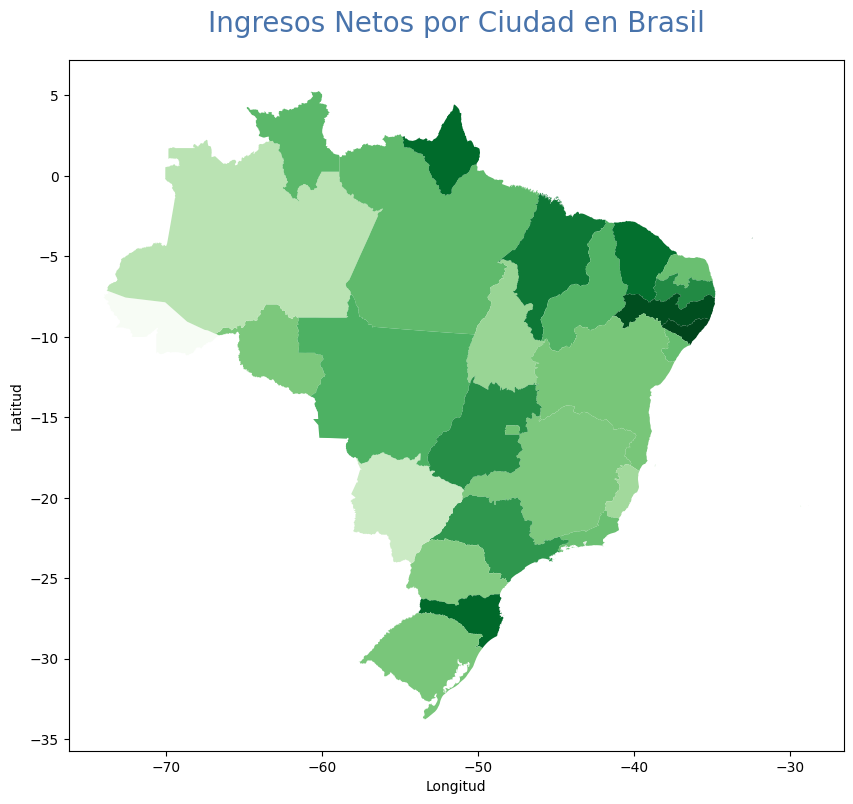

In [112]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Ingresos Netos por Ciudad en Brasil', 
             pad=20, 
             fontdict={'fontsize': 20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Mostrar el mapa finalizado
br_uf_d.plot(column='ingreso_neto', cmap='Greens', ax=ax, zorder=5)

C:\Users\eddwi\AppData\Local\Temp\ipykernel_40208\4286336375.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([formatter(tick) for tick in cbar_ticks], fontsize=10)  # Formatea las etiquetas de los ticks de la barra de leyenda


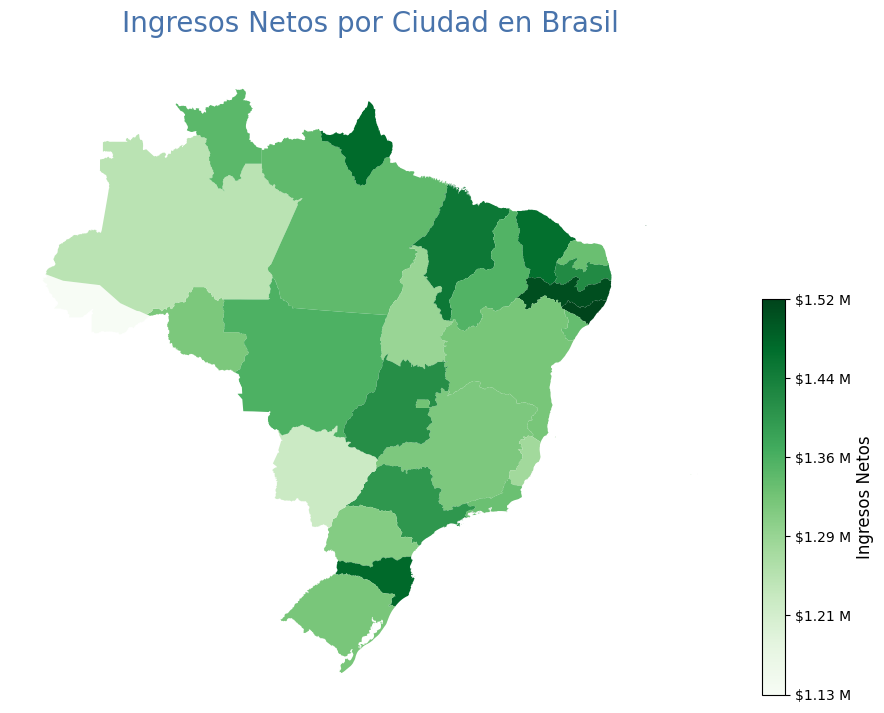

In [127]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title('Ingresos Netos por Ciudad en Brasil', 
             pad=20, 
             fontdict={'fontsize': 20, 'color': '#4873ab'})

# Ocultar los ejes
ax.axis('off')

# Mostrar el mapa finalizado
br_uf_d.plot(column='ingreso_neto', cmap='Greens', ax=ax, zorder=5)

# Crear una barra de leyenda personalizada
cbar_label = 'Ingresos Netos'

formatter = ticker.FuncFormatter(lambda x, pos: '${:,.2f} M'.format(x / 1000000)) 
locator = MaxNLocator(nbins=7) 
cbar_ticks = np.linspace(br_uf_d['ingreso_neto'].min(), br_uf_d['ingreso_neto'].max(), num=6)  # Define los ticks de la barra de leyenda
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Greens'), ax=ax, fraction=0.03, pad=0.04, aspect=17, format=formatter)  # Ajusta la ubicación y el tamaño de la barra de leyenda
cbar.ax.set_ylabel(cbar_label, rotation=90, fontsize=12)
cbar.ax.set_yticklabels([formatter(tick) for tick in cbar_ticks], fontsize=10)  # Formatea las etiquetas de los ticks de la barra de leyenda

cbar.ax.set_position([cbar.ax.get_position().x0, -0.006, cbar.ax.get_position().width, cbar.ax.get_position().height])

plt.show() 